In [1]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

import timm

assert timm.__version__ == "0.3.2" # 버전 체크 - timm 0.3.2 버전 확인
from timm.models.layers import trunc_normal_
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

# 커스텀 유틸리티 모듈들 임포트
import util.lr_decay as lrd  # 학습률 스케줄링
import util.misc as misc  # 기타 유틸리티 함수들
from util.datasets import build_dataset  # 데이터셋 생성
from util.pos_embed import interpolate_pos_embed  # 위치 임베딩 보간
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import models_vit  # Vision Transformer 모델

from engine_finetune import train_one_epoch, evaluate  # 훈련 및 평가 엔진


In [2]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, transforms
import PIL
def build_transform(is_train):
    input_size = 224
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD
    # train transform

    # eval transform
    t = []
    if input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
    )
    t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)


def build_dataset(is_train):
    transform = build_transform(is_train)
    data_path = "/data/docparser_mh/temp/data/ImageNet"
    root = os.path.join(data_path, 'train' if is_train else 'val')
    dataset = datasets.ImageFolder(root, transform=transform)

    print(dataset)

    return dataset

In [3]:
device = torch.device("cuda")
# 재현성을 위한 시드 고정
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True  # CuDNN 성능 최적화

# 훈련 및 검증 데이터셋 구성
# dataset_train = build_dataset(is_train=True, args=args)
dataset_val = build_dataset(is_train=False)

# 분산 훈련을 위한 데이터 샘플러 설정

sampler_val = torch.utils.data.SequentialSampler(dataset_val)

# 텐서보드 로거 설정
log_writer = None

# 데이터 로더 생성
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=4,
    num_workers=0,
    pin_memory=False,
    drop_last=False  # 검증 시에는 모든 샘플 사용
)

# Vision Transformer 모델 생성
model = models_vit.__dict__["vit_base_patch16"](
    num_classes=1000,
    drop_path_rate=0.1,
    global_pool=True,
    mask_ratio=0.4,
)

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: /data/docparser_mh/temp/data/ImageNet/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [4]:
FineTune = "/data/docparser_mh/temp/mae_temp/checkpoint-94.pth"

checkpoint = torch.load(FineTune, map_location='cpu', weights_only=False)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()


for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"사전 훈련 체크포인트에서 키 {k} 제거")
        del checkpoint_model[k]

# 위치 임베딩 보간 (입력 크기가 다를 수 있음)
interpolate_pos_embed(model, checkpoint_model)

# 사전 훈련된 모델 로드
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

# Energy-based masking 관련 새로운 파라미터들 허용
expected_missing_keys = {'head.weight', 'head.bias'}
energy_masking_keys = {
    'register_token', 'energy_threshold', 
    'state_vectors.weight', 'state_vectors.bias',
    'energy_func_td.weight', 'energy_func_td.bias',
    'energy_func_bu.weight', 'energy_func_bu.bias', 
    'energy_func_lr.weight', 'energy_func_lr.bias',
    'energy_func_rl.weight', 'energy_func_rl.bias'
}

# if args.global_pool:
#     expected_missing_keys.update({'fc_norm.weight', 'fc_norm.bias'})
    
# Energy-based masking 파라미터들도 허용
expected_missing_keys.update(energy_masking_keys)

# 실제 missing keys가 예상된 범위 내에 있는지 확인
actual_missing = set(msg.missing_keys)
if not actual_missing.issubset(expected_missing_keys):
    unexpected_missing = actual_missing - expected_missing_keys
    print(f"Warning: Unexpected missing keys: {unexpected_missing}")
    # assert False, f"Unexpected missing keys: {unexpected_missing}"

# 분류 레이어 수동 초기화
trunc_normal_(model.head.weight, std=2e-5)


model.to(device)

_IncompatibleKeys(missing_keys=['register_token', 'energy_threshold', 'pred_conv.parametrizations.weight.original', 'pred_conv.parametrizations.weight.0.mask'], unexpected_keys=[])


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x CustomBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=768, out_features=1000, bias=True)
  (fc_norm): LayerN

In [5]:
import torch.nn.functional as F

for data_iter_step, (samples, targets) in enumerate(data_loader_val):
    samples = samples.to(device)
    targets = targets.to(device)

    x = samples
    B = x.shape[0]
    x_feat = model.patch_embed(x) # (4, 196, 768)
    x_feat = x_feat + model.pos_embed[:, 1:, :]
    q, keep_idx, rec_loss, cos = model.energy_based_masking(x_feat)

    H, W = model.img_size
    patch_H, patch_W = H // model.patch_size, W // model.patch_size
    B, L = keep_idx.shape

    mask = torch.zeros((B, patch_H, patch_W))
    mask = mask.reshape(B, -1)
    # mask[]
    keep_idx = keep_idx.cpu()
    
    # print(keep_idx.shape)
    # mask[keep_idx] = 1
    for i in range(len(mask)):
        mask[i][keep_idx[i]] = 1
    mask = mask.reshape(B, patch_H, patch_W)
    print(mask.shape)
    print(B, H, W)
    mask = mask.unsqueeze(1)

    mask = F.interpolate(mask, size=(H, W), mode='nearest')
    mask = mask.squeeze()
    print(mask.shape)
    break

torch.Size([4, 14, 14])
4 224 224
torch.Size([4, 224, 224])


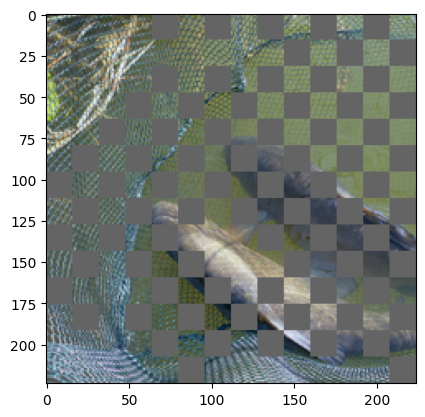

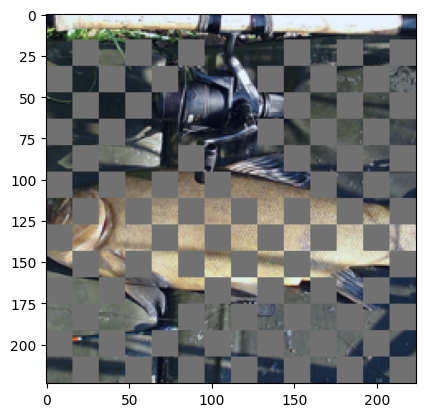

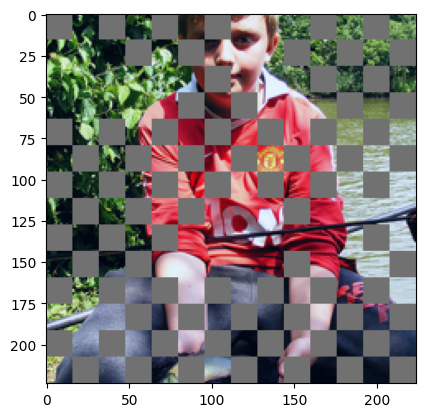

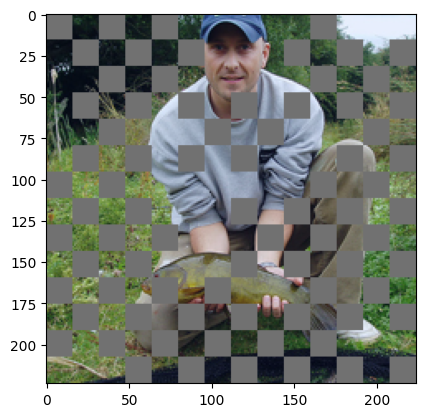

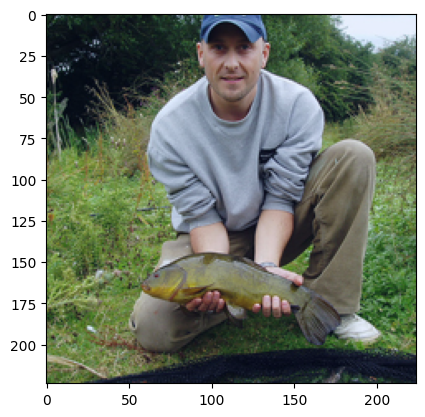

In [6]:
from matplotlib import pyplot as plt
idx = 3
for idx in range(len(samples)):



    image = samples[idx].cpu() * mask[idx]
    image -= image.min()
    image /= image.max()
    plt.imshow(image.permute(1,2,0))
    plt.show()

image_original = samples[idx].cpu()
image_original -= image_original.min()
image_original /= image_original.max()
plt.imshow(image_original.permute(1,2,0))
plt.show()

In [8]:
A = [[1, 0],[0,1]]
B = [[1,1,0,0], [1,1,0,0], [0,0,1,1], [0,0,1,1]]

In [9]:
import torch.nn.functional as F

a = torch.randn(4, 196, 768)
b = torch.randn(4, 196, 768)
F.l1_loss(a, b, reduction='none')

tensor([[[1.0304e+00, 3.2570e+00, 3.1607e-01,  ..., 1.9707e+00,
          1.1801e-01, 7.0017e-01],
         [1.1123e+00, 7.1923e-02, 2.1282e-01,  ..., 7.9178e-01,
          1.2766e+00, 2.4521e-01],
         [1.6248e+00, 8.8024e-01, 8.6445e-02,  ..., 4.2692e-01,
          1.4772e+00, 4.6123e-01],
         ...,
         [1.9818e+00, 3.5918e-02, 1.2944e+00,  ..., 3.2971e+00,
          1.5622e+00, 5.8474e-01],
         [5.7307e-01, 6.4439e-01, 2.0050e+00,  ..., 2.1637e+00,
          1.8267e+00, 1.7433e+00],
         [1.2960e+00, 1.3201e+00, 1.8063e+00,  ..., 1.4417e+00,
          1.2537e+00, 9.4424e-02]],

        [[2.2533e+00, 5.5355e-01, 7.7133e-01,  ..., 2.6140e+00,
          1.0023e+00, 6.9020e-01],
         [1.0063e+00, 2.7907e+00, 6.3558e-01,  ..., 1.6843e+00,
          1.5466e-01, 1.0541e+00],
         [7.5083e-01, 8.4097e-02, 2.8315e+00,  ..., 9.3552e-02,
          7.9197e-01, 1.2640e+00],
         ...,
         [1.4673e+00, 2.2884e+00, 2.1787e+00,  ..., 2.3584e+00,
          4.464

# 전체 데이터에서 필요없는걸 시각화

100%|██████████| 1563/1563 [12:44<00:00,  2.04it/s]


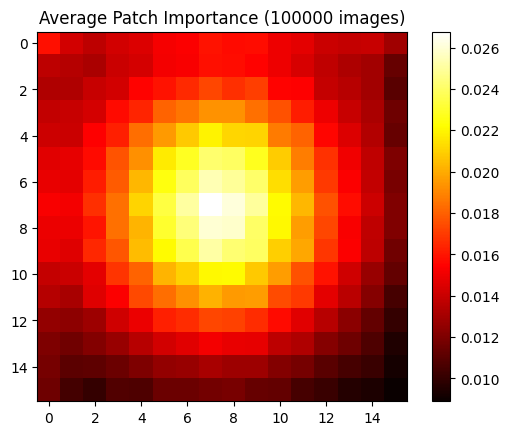

In [ ]:

# ---------------------------
# 2. 사전학습된 모델 로드 (ResNet50)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(pretrained=True).to(device)
model.eval()

# ---------------------------
# 3. 중요도 계산 함수 (패치 단위)
# ---------------------------
def compute_batch_patch_importance(imgs, model, num_patches=16):
    """
    imgs: (B, 3, 224, 224)
    model: pretrained model
    num_patches: 가로/세로 패치 개수
    """
    B, _, H, W = imgs.shape
    patch_H, patch_W = H // num_patches, W // num_patches

    imgs = imgs.clone().detach().to(device)
    imgs.requires_grad_(True)

    # 모델 forward
    outputs = model(imgs)
    preds = outputs.argmax(dim=1)  # 각 이미지의 예측 클래스 선택

    # batch별로 gradient 계산
    loss = outputs[torch.arange(B), preds].sum()
    loss.backward()

    # 입력에 대한 gradient
    grads = imgs.grad.detach().abs().mean(dim=1)  # (B, H, W)

    # 각 이미지별 패치 중요도 계산
    batch_importance = torch.zeros((B, num_patches, num_patches), device=device)
    for i in range(num_patches):
        for j in range(num_patches):
            patch = grads[:, i*patch_H:(i+1)*patch_H, j*patch_W:(j+1)*patch_W]
            batch_importance[:, i, j] = patch.mean(dim=(1,2))

    return batch_importance.cpu().numpy()

# ---------------------------
# 4. 전체 데이터에 대해 누적 후 평균
# ---------------------------

from tqdm import tqdm

num_patches = 16
importance_accum = np.zeros((num_patches, num_patches))
num_samples = 0

for imgs, _ in tqdm(dataloader):
    batch_importance = compute_batch_patch_importance(imgs, model, num_patches=num_patches)
    importance_accum += batch_importance.sum(axis=0)  # 배치 내 합산
    num_samples += batch_importance.shape[0]

importance_mean = importance_accum / num_samples

# ---------------------------
# 5. 시각화
# ---------------------------
plt.imshow(importance_mean, cmap="hot")
plt.colorbar()
plt.title(f"Average Patch Importance ({num_samples} images)")
plt.show()


/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1563/1563 [12:21<00:00,  2.11it/s]


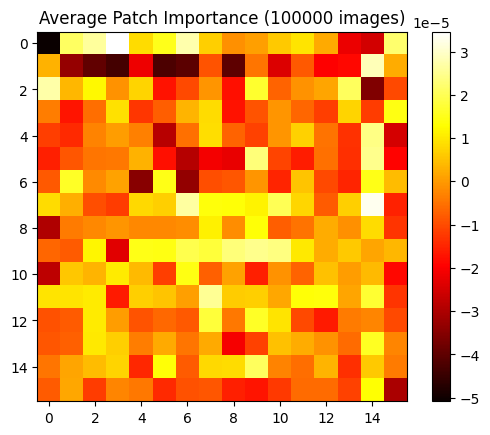

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. ImageNet Validation Dataset 로드
# ---------------------------
data_dir = "/data/docparser_mh/temp/data/ImageNet/"  # <- 여기를 실제 validation set 경로로 바꿔주세요.

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # 모델 입력 크기 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# ---------------------------
# 2. 사전학습된 모델 로드 (ResNet50)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(pretrained=True).to(device)
model.eval()

# ---------------------------
# 3. 중요도 계산 함수 (패치 단위)
# ---------------------------
def compute_batch_patch_importance(imgs, model, num_patches=16):
    """
    imgs: (B, 3, 224, 224)
    model: pretrained model
    num_patches: 가로/세로 패치 개수
    """
    B, _, H, W = imgs.shape
    patch_H, patch_W = H // num_patches, W // num_patches

    imgs = imgs.clone().detach().to(device)
    imgs.requires_grad_(True)

    # 모델 forward
    outputs = model(imgs)
    preds = outputs.argmax(dim=1)  # 각 이미지의 예측 클래스 선택

    # batch별로 gradient 계산
    loss = outputs[torch.arange(B), preds].sum()
    loss.backward()

    # 입력에 대한 gradient
    grads = imgs.grad.detach()  # (B, H, W)
    GI = grads * imgs.detach()
    GI = GI.mean(dim=1)  # (B, H, W)
    # 각 이미지별 패치 중요도 계산
    batch_importance = torch.zeros((B, num_patches, num_patches), device=device)
    for i in range(num_patches):
        for j in range(num_patches):
            patch = GI[:, i*patch_H:(i+1)*patch_H, j*patch_W:(j+1)*patch_W]
            batch_importance[:, i, j] = patch.mean(dim=(1,2))

    return batch_importance.cpu().numpy()

# ---------------------------
# 4. 전체 데이터에 대해 누적 후 평균
# ---------------------------

from tqdm import tqdm

num_patches = 16
importance_accum = np.zeros((num_patches, num_patches))
num_samples = 0

for imgs, _ in tqdm(dataloader):
    batch_importance = compute_batch_patch_importance(imgs, model, num_patches=num_patches)
    importance_accum += batch_importance.sum(axis=0)  # 배치 내 합산
    num_samples += batch_importance.shape[0]

importance_mean = importance_accum / num_samples

# ---------------------------
# 5. 시각화
# ---------------------------
plt.imshow(importance_mean, cmap="hot")
plt.colorbar()
plt.title(f"Average Patch Importance ({num_samples} images)")
plt.show()


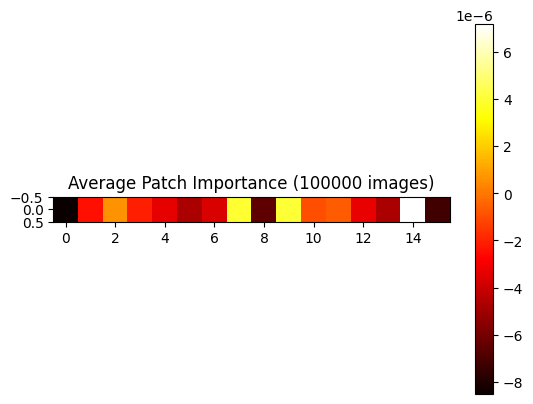

In [33]:
plt.imshow(np.expand_dims(importance_mean.mean(axis=0), axis=0), cmap="hot")
plt.colorbar()
plt.title(f"Average Patch Importance ({num_samples} images)")
plt.show()


In [36]:
np.expand_dims(importance_mean.mean(axis=0), axis=0)

array([[-8.51530562e-06, -2.42527359e-06,  6.58125650e-07,
        -2.05794182e-06, -3.33800486e-06, -4.77038066e-06,
        -3.65751943e-06,  3.96595999e-06, -6.55070883e-06,
         4.01517469e-06, -9.75391582e-07, -6.18820706e-07,
        -3.28396411e-06, -4.75551647e-06,  7.16637114e-06,
        -7.16856245e-06]])

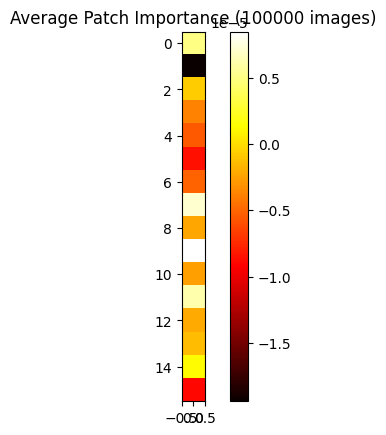

In [35]:
plt.imshow(np.expand_dims(importance_mean.mean(axis=1), axis=1), cmap="hot")
plt.colorbar()
plt.title(f"Average Patch Importance ({num_samples} images)")
plt.show()


# 전체 데이터에서 gradient가 어떻게 쌓이는지 시각화 (ViT 사용)

In [48]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

import timm

assert timm.__version__ == "0.3.2" # 버전 체크 - timm 0.3.2 버전 확인
from timm.models.layers import trunc_normal_
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

# 커스텀 유틸리티 모듈들 임포트
import util.lr_decay as lrd  # 학습률 스케줄링
import util.misc as misc  # 기타 유틸리티 함수들
from util.datasets import build_dataset  # 데이터셋 생성
from util.pos_embed import interpolate_pos_embed  # 위치 임베딩 보간
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import models_vit  # Vision Transformer 모델

from engine_finetune import train_one_epoch, evaluate  # 훈련 및 평가 엔진

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, transforms
import PIL
def build_transform(is_train):
    input_size = 224
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD
    # train transform

    # eval transform
    t = []
    if input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
    )
    t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)


def build_dataset(is_train):
    transform = build_transform(is_train)
    data_path = "/data/docparser_mh/temp/data/ImageNet"
    root = os.path.join(data_path, 'train' if is_train else 'val')
    dataset = datasets.ImageFolder(root, transform=transform)

    print(dataset)

    return dataset


device = torch.device("cuda")
# 재현성을 위한 시드 고정
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True  # CuDNN 성능 최적화

# 훈련 및 검증 데이터셋 구성
# dataset_train = build_dataset(is_train=True, args=args)
dataset_val = build_dataset(is_train=False)

# 분산 훈련을 위한 데이터 샘플러 설정

sampler_val = torch.utils.data.SequentialSampler(dataset_val)

# 텐서보드 로거 설정
log_writer = None

# 데이터 로더 생성
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=4,
    num_workers=0,
    pin_memory=False,
    drop_last=False  # 검증 시에는 모든 샘플 사용
)

# Vision Transformer 모델 생성
model = models_vit.__dict__["vit_base_patch16"](
    num_classes=1000,
    drop_path_rate=0.1,
    global_pool=True,
    mask_ratio=0.4,
)


FineTune = "/data/docparser_mh/temp/mae_temp/checkpoint-94.pth"

checkpoint = torch.load(FineTune, map_location='cpu', weights_only=False)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()


for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"사전 훈련 체크포인트에서 키 {k} 제거")
        del checkpoint_model[k]

# 위치 임베딩 보간 (입력 크기가 다를 수 있음)
interpolate_pos_embed(model, checkpoint_model)

# 사전 훈련된 모델 로드
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

# Energy-based masking 관련 새로운 파라미터들 허용
expected_missing_keys = {'head.weight', 'head.bias'}
energy_masking_keys = {
    'register_token', 'energy_threshold', 
    'state_vectors.weight', 'state_vectors.bias',
    'energy_func_td.weight', 'energy_func_td.bias',
    'energy_func_bu.weight', 'energy_func_bu.bias', 
    'energy_func_lr.weight', 'energy_func_lr.bias',
    'energy_func_rl.weight', 'energy_func_rl.bias'
}

# if args.global_pool:
#     expected_missing_keys.update({'fc_norm.weight', 'fc_norm.bias'})
    
# Energy-based masking 파라미터들도 허용
expected_missing_keys.update(energy_masking_keys)

# 실제 missing keys가 예상된 범위 내에 있는지 확인
actual_missing = set(msg.missing_keys)
if not actual_missing.issubset(expected_missing_keys):
    unexpected_missing = actual_missing - expected_missing_keys
    print(f"Warning: Unexpected missing keys: {unexpected_missing}")
    # assert False, f"Unexpected missing keys: {unexpected_missing}"

# 분류 레이어 수동 초기화
trunc_normal_(model.head.weight, std=2e-5)


model.to(device)




Dataset ImageFolder
    Number of datapoints: 50000
    Root location: /data/docparser_mh/temp/data/ImageNet/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
_IncompatibleKeys(missing_keys=['register_token', 'energy_threshold', 'pred_conv.parametrizations.weight.original', 'pred_conv.parametrizations.weight.0.mask'], unexpected_keys=[])


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x CustomBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=768, out_features=1000, bias=True)
  (fc_norm): LayerN

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

model_without_ddp = model
weight_decay = 0.05
layer_decay = 0.75
accum_iter = 1

param_groups = lrd.param_groups_lrd(model_without_ddp, weight_decay,
        no_weight_decay_list=model_without_ddp.no_weight_decay(),
        layer_decay=layer_decay
    )
criterion = torch.nn.CrossEntropyLoss()
loss_scaler = NativeScaler()
optimizer = torch.optim.AdamW(param_groups, lr=0.001)

grad_accum = torch.zeros(16,16)
for data_iter_step, (x, targets) in tqdm(enumerate(data_loader_val), total=len(data_loader_val)):
    x = x.to(device)
    targets = targets.to(device)
    B = x.shape[0]
    x = model.patch_embed(x) # (4, 196, 768)
    x = x + model.pos_embed[:, 1:, :]
    q = x
    # q.requires_grad_(True)
    # q.retain_grad()
    # imgs.requires_grad_(True)

    cls_token = model.cls_token + model.pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(B, -1, -1)
    
    q = torch.cat((cls_tokens, q), dim=1)
    q = model.pos_drop(q)
    
    x = torch.cat((cls_tokens, x), dim=1)  # 클래스 토큰 추가
    x = model.pos_drop(x)  # 포지션 드롭
    
    # K, V 입력 지정 (없으면 Q와 동일)

    # 커스텀 블록 순차 적용
    for blk in model.blocks:
        q = blk(q, x, x)
    x = q
    if model.global_pool:
        x = x[:, 1:, :].mean(dim=1)
        outcome = model.fc_norm(x)
    else:
        x = model.norm(x)
        outcome = x[:, 0]
        

    x = outcome
    x = model.head(x)

    loss = criterion(x, targets)
    q.retain_grad()
    
    loss_scaler(loss, optimizer, clip_grad=0,
            parameters=model.parameters(), create_graph=False,
            update_grad=(data_iter_step + 1) % accum_iter == 0)
    grad_accum += q.grad.mean(dim=0).reshape(16,16,-1).mean(-1).cpu()
    
    # zero grad
    optimizer.zero_grad()

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

torch.Size([197, 768])


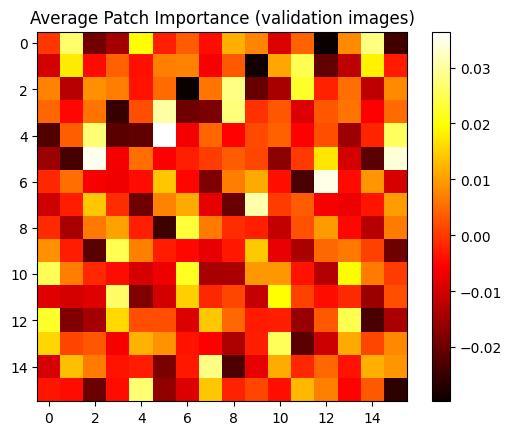

In [7]:
from matplotlib import pyplot as plt

# ---------------------------
# 5. 시각화
# ---------------------------
plt.imshow(grad_accum, cmap="hot")
plt.colorbar()
plt.title(f"Average Patch Importance (validation images)")
plt.show()


In [49]:
import torch.nn.functional as F
from tqdm import tqdm

model_without_ddp = model
weight_decay = 0.05
layer_decay = 0.75
accum_iter = 1

param_groups = lrd.param_groups_lrd(model_without_ddp, weight_decay,
        no_weight_decay_list=model_without_ddp.no_weight_decay(),
        layer_decay=layer_decay
    )
criterion = torch.nn.CrossEntropyLoss()
loss_scaler = NativeScaler()
optimizer = torch.optim.AdamW(param_groups, lr=0.001)

grad_accum_q = torch.zeros(14,14)
grad_accum_q_gi = torch.zeros(14,14)

grad_accum_img = torch.zeros(224,224)
grad_accum_img_gi = torch.zeros(224,224)
for data_iter_step, (imgs, targets) in tqdm(enumerate(data_loader_val), total=len(data_loader_val)):
    imgs = imgs.to(device)
    imgs.requires_grad_(True)
    targets = targets.to(device)
    B = imgs.shape[0]
    x = model.patch_embed(imgs) # (4, 196, 768)
    x = x + model.pos_embed[:, 1:, :]
    q = x
    # q.requires_grad_(True)
    # q.retain_grad()
    # imgs.requires_grad_(True)

    cls_token = model.cls_token + model.pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(B, -1, -1)
    
    q_ = torch.cat((cls_tokens, q), dim=1)
    q_ = model.pos_drop(q_)
    
    x = torch.cat((cls_tokens, x), dim=1)  # 클래스 토큰 추가
    x = model.pos_drop(x)  # 포지션 드롭
    
    # K, V 입력 지정 (없으면 Q와 동일)

    # 커스텀 블록 순차 적용
    for blk in model.blocks:
        q_ = blk(q_, x, x)
    x = q_
    if model.global_pool:
        x = x[:, 1:, :].mean(dim=1)
        outcome = model.fc_norm(x)
    else:
        x = model.norm(x)
        outcome = x[:, 0]
        

    x = outcome
    x = model.head(x)

    loss = criterion(x, targets)
    q.retain_grad()
    
    loss_scaler(loss, optimizer, clip_grad=0,
            parameters=model.parameters(), create_graph=False,
            update_grad=(data_iter_step + 1) % accum_iter == 0)
    

    grads_abs = imgs.grad.detach().abs().mean(dim=0).mean(dim=0)
    grads = imgs.grad.detach()
    GI = grads * imgs.detach()
    GI = GI.mean(dim=0).mean(dim=0)  # (Batch에 대해 평균)
    grad_accum_img += grads_abs.cpu()
    grad_accum_img_gi += GI.cpu()



    grads_abs = q.grad.detach().abs().mean(dim=0).mean(dim=1)

    grads = q.grad.detach()
    GI = grads * q.detach()
    GI = GI.mean(dim=0).mean(dim=1)  # (Batch에 대해 평균)
    # print(q.shape)
    # print(grads_abs.shape)
    # print(GI.shape)
    grad_accum_q += grads_abs.reshape((14,14)).cpu()
    grad_accum_q_gi += GI.reshape((14,14)).cpu()


    # grad_accum += q.grad.mean(dim=0).reshape(16,16,-1).mean(-1).cpu()
    
    # zero grad
    optimizer.zero_grad()


100%|██████████| 12500/12500 [23:09<00:00,  8.99it/s]


In [51]:
print(grad_accum_img.shape)
print(grad_accum_img_gi.shape)
print(grad_accum_q.shape)
print(grad_accum_q_gi.shape)


torch.Size([224, 224])
torch.Size([224, 224])
torch.Size([14, 14])
torch.Size([14, 14])


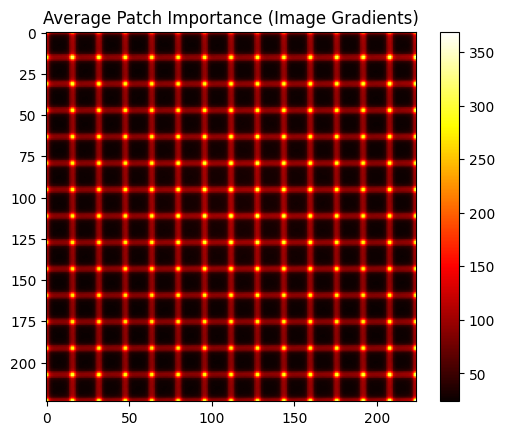

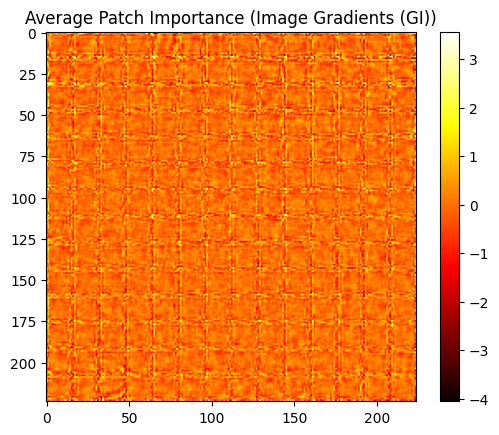

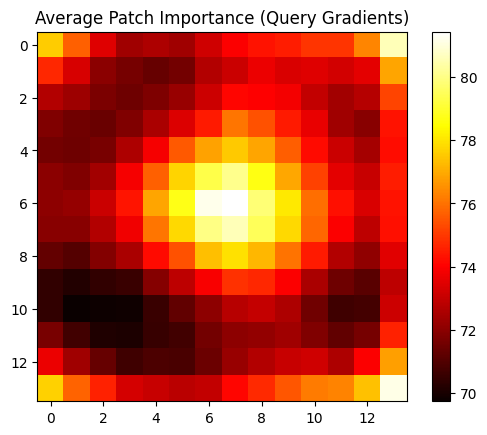

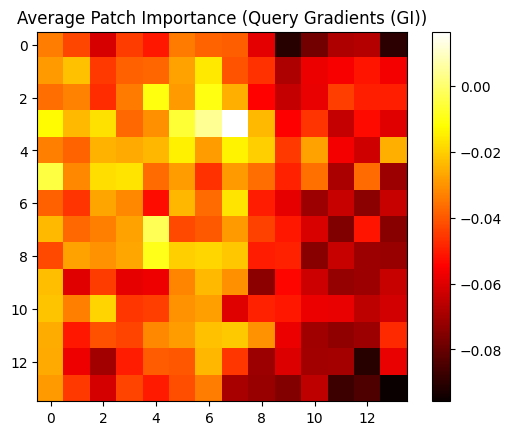

In [52]:
# ---------------------------
# 5. 시각화
# ---------------------------

for title, d in [("Image Gradients", grad_accum_img), ("Image Gradients (GI)", grad_accum_img_gi), ("Query Gradients", grad_accum_q), ("Query Gradients (GI)", grad_accum_q_gi)]:

    plt.imshow(d, cmap="hot")
    plt.colorbar()
    plt.title(f"Average Patch Importance ({title})")
    plt.show()


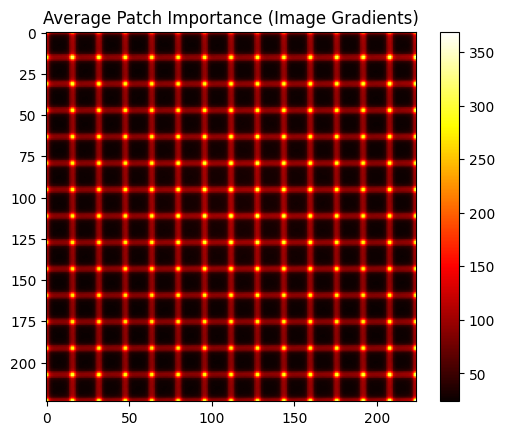

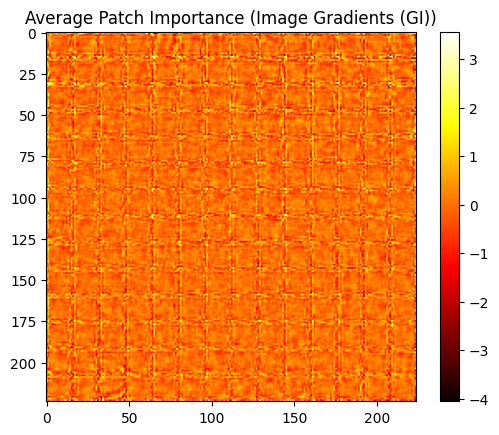

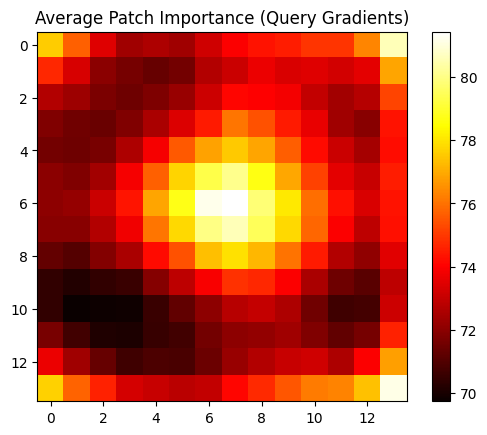

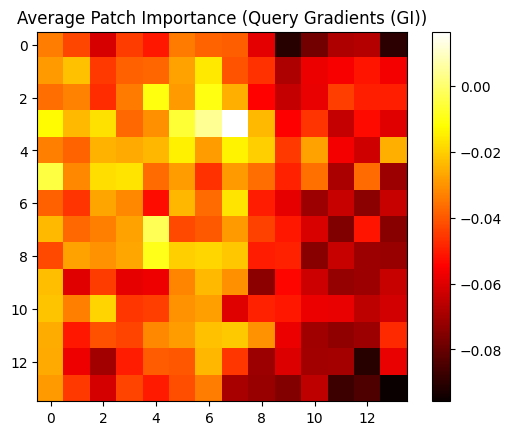

In [53]:
# ---------------------------
# 5. 시각화
# ---------------------------

for title, d in [("Image Gradients", grad_accum_img), ("Image Gradients (GI)", grad_accum_img_gi), ("Query Gradients", grad_accum_q), ("Query Gradients (GI)", grad_accum_q_gi)]:

    plt.imshow(d, cmap="hot")
    plt.colorbar()
    plt.title(f"Average Patch Importance ({title})")
    plt.show()
